In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
import torch.backends.cudnn as cudnn
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError as SMAPE, MeanAbsolutePercentageError as MAPE, R2Score as R2
# import wandb

In [3]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

if torch.cuda.is_available(): device = torch.device("cuda")
elif torch.backends.mps.is_available(): device = torch.device("mps")
else: device = torch.device('cpu')

In [4]:
device

device(type='cuda')

In [ ]:
# wandb.init()
# wandb.run.name = 'lstm'
# wandb.run.save()

In [5]:
# class GasDataset(Dataset):
#     def __init__(self, df, seq_len, year=None):
#         self.seq_len = seq_len

#         self.df = df
#         if year is not None:
#             self.df = self.df.loc[self.df['year'] == year]
    
#     def __len__(self):
#         return len(self.df) - self.seq_len - 1

#     def __getitem__(self, idx):
#         data = self.df.iloc[idx:idx + self.seq_len]
#         date, x = data.date, torch.from_numpy(np.array(data[['supply']], dtype=np.float32))
#         y = torch.from_numpy(np.array(self.df.iloc[idx + self.seq_len, -4], dtype=np.float32))

#         return x, y
    
class ElecDataset(Dataset):
    def __init__(self, df, seq_len, is_val=False, pred_len=None):
        self.df = df
        self.seq_len = seq_len
        self.is_val = is_val
        self.pred_len = pred_len

    def __len__(self):
        if not self.is_val:
            return len(self.df) - self.seq_len - 1
        else:
            return len(self.df) - self.seq_len - self.pred_len - 1
        
    def __getitem__(self, idx):
        input_data = np.array(self.df[idx : idx + self.seq_len])
        if not self.is_val:
            output_data = np.array(self.df[idx + self.seq_len])
        else:
            output_data = np.array(self.df[idx + self.seq_len : idx + self.seq_len + self.pred_len])

        return torch.FloatTensor(input_data), torch.FloatTensor(output_data)

In [11]:
pmj_df = pd.read_csv("./data/kaggle_data/pjm_elec_daily.csv")

pmj_cols = ['AEP', 'COMED', 'DAYTON', 'DEOK', 'DOM', 'DUQ', 'FE', 'NI', 'PJME', 'PJMW']
pmj_train_dict = {}
pmj_val_dict = {}

seq_len = 120
pred_len = 60

train_dl_list, val_ds_list = [], []

for col in pmj_cols:
    df = pmj_df.loc[pmj_df[col] != 0, col]
    df = df.reset_index()[col]
    train_len = int(0.8 * len(df))
    train_df, test_df = df.iloc[:train_len], df.iloc[train_len:]
    
    scaler = MinMaxScaler()
    train_np = scaler.fit_transform(np.array(train_df).reshape(-1, 1))
    test_np = scaler.transform(np.array(test_df).reshape(-1, 1))

    print(train_np.shape, test_np.shape)

    train_dataset = ElecDataset(train_np, seq_len)
    val_dataset = ElecDataset(test_np, seq_len, True, pred_len)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    
    train_dl_list.append((col, train_loader, scaler))
    val_ds_list.append((col, val_dataset, scaler))

(4044, 1) (1011, 1)
(2217, 1) (555, 1)
(4044, 1) (1011, 1)
(1925, 1) (482, 1)
(3874, 1) (969, 1)
(3970, 1) (993, 1)
(2096, 1) (525, 1)
(1949, 1) (488, 1)
(4847, 1) (1212, 1)
(4775, 1) (1194, 1)


In [12]:
#https://pseudo-lab.github.io/Tutorial-Book/chapters/time-series/Ch5-CNN-LSTM.html
class TensorExtractor(nn.Module):
    def forward(self, x):
        tensor, _ = x
        return tensor
class ReshapeData(nn.Module):
    def __init__(self, seq_len, is_input=True):
        super(ReshapeData, self).__init__()
        self.seq_len = seq_len
        self.is_input = is_input
    def forward(self, x):
        if self.is_input:
            return x.unsqueeze(1)
        else:
            return x.squeeze(1)

    
class Model(nn.Module):
    def __init__(self, model_name, input_size, hidden_size, num_layer):
        super(Model, self).__init__()
        model_layers = []
        model_layers.append(nn.BatchNorm1d(input_size))
        if model_name == 'lstm':
            model_layers.append(nn.LSTM(input_size, hidden_size, num_layer, batch_first=True))
        elif model_name == 'gru':
            model_layers.append(nn.GRU(input_size, hidden_size, num_layer, batch_first=True))
        elif model_name == 'rnn':
            model_layers.append(nn.RNN(input_size, hidden_size, num_layer, batch_first=True))
        model_layers.append(TensorExtractor())
        model_layers.append(nn.BatchNorm1d(hidden_size))
        model_layers.append(nn.Linear(hidden_size, 1))
        self.model = nn.Sequential(*model_layers)
    
    def forward(self, x):
        return self.model(x)

In [19]:
train_rate = 0.8
# df = pd.read_csv("data/korea/kor_gas_day.csv")
# df = df.loc[df['type'] == 'A']
# train_len = int(len(df) * train_rate)

# train_dataset = GasDataset(df_train, seq_len)

batch_szie = 32

# gru: 100-2 -> 127981
# lstm: 80-2 -> 117201
# rnn: 180-2 -> 120541
# transformer: 32-512-2 -> 113025
model_fig = [('gru', 50, 1),
             ('lstm', 50, 1),
             ('rnn', 50, 1)]
model_name, hidden_szie, num_layers = model_fig[1]
model = Model(model_name, seq_len, hidden_szie, num_layers).to(device)
 
# train_loader = DataLoader(train_dataset, batch_size=batch_szie, shuffle=True)

# model.eval()
# for batch_idx, (x, y) in enumerate(train_loader):
#     x = x.squeeze(-1).to(device)
#     y = y.unsqueeze(-1).to(device)
#     print(x.shape, y.shape)
#     output = model(x)
#     print(output.shape)
#     break

In [20]:
# from pmdarima.utils import diff, diff_inv

def train(model, train_loader_list, optimizer, criterion, epoch):
    model.train()
    for i in tqdm(range(epoch)):
        for _, train_loader, _ in train_loader_list:
            for batch_idx, (x, y) in enumerate(train_loader):
                x = x.squeeze(-1).to(device)
                y = y.unsqueeze(-1).to(device)
                
                optimizer.zero_grad()
                output = model(x)
                
                loss = criterion(output, y)
                loss.backward()
                optimizer.step()
                # wandb.log({
                #     "epoch": i,
                #     "Loss": loss,
                #     'x': x,
                #     'y': y
                # })
        if i % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i, epoch,
                100. * i / epoch, loss.item()))

def predict_plot(model, val_data_list):
    smape = SMAPE()
    mse = nn.MSELoss()
    mape = MAPE()
    r2 = R2(pred_len)
    model.eval()
    tot_len = 0
    total_rmse, total_mape, total_smape, total_r2 = 0, 0, 0, 0
    sub_num = 1
    plt.figure(figsize=(20, 15))
    true_val_list, predictions_list = [], []
    type_len = len(val_data_list)
    for t, val_dataset, scaler in val_data_list:
        rmse_score, mape_score, smape_score, r2_score = 0, 0, 0, 0
        true_vals, predictions = [], []
        for i in range(len(val_dataset)):
            x, true_val = val_dataset[i] # true_val 이상함
            x = x.to(device)

            with torch.no_grad():
                for _ in range(pred_len):
                    x = x.view(1, -1)
                    output = model(x).squeeze(-1)
                    tmp = x[0][1:].unsqueeze(0)
                    x = torch.cat([tmp, output[:1].unsqueeze(0)], dim=1)
                    
            true_vals.append(scaler.inverse_transform(np.array(true_val).squeeze().reshape(-1, 1)).squeeze())
            predictions.append(scaler.inverse_transform(np.array(x[0][pred_len:].detach().cpu()).squeeze().reshape(-1, 1)).squeeze())

        rmse_score += mse(torch.FloatTensor(predictions), torch.FloatTensor(true_vals)) ** 0.5 * len(val_dataset)
        mape_score += mape(torch.FloatTensor(predictions), torch.FloatTensor(true_vals)) * len(val_dataset)
        smape_score += smape(torch.FloatTensor(predictions), torch.FloatTensor(true_vals)) * len(val_dataset)
        r2_score += r2(torch.FloatTensor(predictions), torch.FloatTensor(true_vals)) * len(val_dataset)

        total_rmse += rmse_score
        total_mape += mape_score
        total_smape += smape_score
        total_r2 += r2_score

        tot_len += len(val_dataset)

        x = np.arange(len(true_val))

        plt.subplot(len(val_data_list) // 2 + 1, 2, sub_num)
        plt.rc('font', size=10)
        plt.plot(x, true_vals[0], label='true', c='blue')
        plt.plot(x, predictions[0], label='predictions', c='red')
        plt.title(t)
        plt.legend()
        
        true_val_list.append((true_vals, scaler))
        predictions_list.append((predictions, scaler))
        sub_num += 1
        print('\n' + t)
        print(f'RMSE: {rmse_score / len(val_dataset)}, MAPE: {mape_score / len(val_dataset)}, SMAPE: {smape_score / len(val_dataset)}, R2: {r2_score / len(val_dataset)}')
        
    print(f'RMSE: {total_rmse / tot_len}, MAPE: {total_mape / tot_len}, SMAPE: {total_smape / tot_len}, R2: {total_r2 / tot_len}')
    plt.tight_layout()
    plt.savefig(f'./graph/{model_name}.png')
    plt.show()

    return true_val_list, predictions_list


In [21]:
pred_len

60

In [22]:
# seq_len = 120
# train_rate = 0.8
# batch_szie = 64

# df = pd.read_csv("data/korea/kor_gas_day.csv")

# train_dl_list = []
# val_ds_list = []

# for t in df['type'].unique():
#     tmp = df.loc[df['type'] == t]

#     df_train, df_val = tmp.iloc[:train_len], tmp.iloc[train_len:]
#     scaler = MinMaxScaler() 
#     npy_train = scaler.fit_transform(np.array(df_train['supply']).reshape(-1, 1))
#     npy_val = scaler.transform(np.array(df_val['supply']).reshape(-1, 1))
    
#     df_train.supply = npy_train
#     df_val.supply = npy_val

#     train_dataset = GasDataset(df_train, seq_len)
#     val_dataset = GasDataset(df_val, seq_len)

#     train_loader = DataLoader(train_dataset, batch_size=batch_szie, shuffle=False)
    
#     train_dl_list.append((t, train_loader, scaler))
#     val_ds_list.append((t, val_dataset, scaler))

In [23]:
learning_rate = 1e-5

epochs = 100

model = Model(model_name, seq_len, hidden_szie, num_layers).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss().to(device)
smape = SMAPE()

  1%|          | 1/100 [00:04<07:17,  4.42s/it]

Train Epoch: 100 [0/100 (0%)]	Loss: 0.101015


 21%|██        | 21/100 [01:27<05:28,  4.15s/it]

Train Epoch: 100 [20/100 (20%)]	Loss: 0.015717


 41%|████      | 41/100 [02:48<03:55,  4.00s/it]

Train Epoch: 100 [40/100 (40%)]	Loss: 0.007419


 61%|██████    | 61/100 [04:08<02:36,  4.02s/it]

Train Epoch: 100 [60/100 (60%)]	Loss: 0.005469


 81%|████████  | 81/100 [05:28<01:15,  4.00s/it]

Train Epoch: 100 [80/100 (80%)]	Loss: 0.004831


100%|██████████| 100/100 [06:45<00:00,  4.05s/it]



AEP
RMSE: 52608.38671875, MAPE: 0.12835130095481873, SMAPE: 0.12034639716148376, R2: -0.48130515217781067

COMED
RMSE: 52145.20703125, MAPE: 0.17112909257411957, SMAPE: 0.1556725651025772, R2: -0.9604859948158264

DAYTON
RMSE: 7162.091796875, MAPE: 0.12178289890289307, SMAPE: 0.11934458464384079, R2: -0.1369570642709732

DEOK
RMSE: 11297.9931640625, MAPE: 0.1209215298295021, SMAPE: 0.12012042850255966, R2: -0.16290432214736938

DOM
RMSE: 48634.55859375, MAPE: 0.14857551455497742, SMAPE: 0.14211545884609222, R2: -0.19503682851791382

DUQ
RMSE: 6152.7587890625, MAPE: 0.1438685655593872, SMAPE: 0.1337767094373703, R2: -0.35561466217041016

FE
RMSE: 24274.6640625, MAPE: 0.10871943831443787, SMAPE: 0.10479264706373215, R2: -0.3354468047618866

NI
RMSE: 51843.21484375, MAPE: 0.16274100542068481, SMAPE: 0.15190748870372772, R2: -0.1316019743680954

PJME
RMSE: 119950.859375, MAPE: 0.13456416130065918, SMAPE: 0.13043905794620514, R2: -0.15985387563705444

PJMW
RMSE: 21978.40625, MAPE: 0.117597

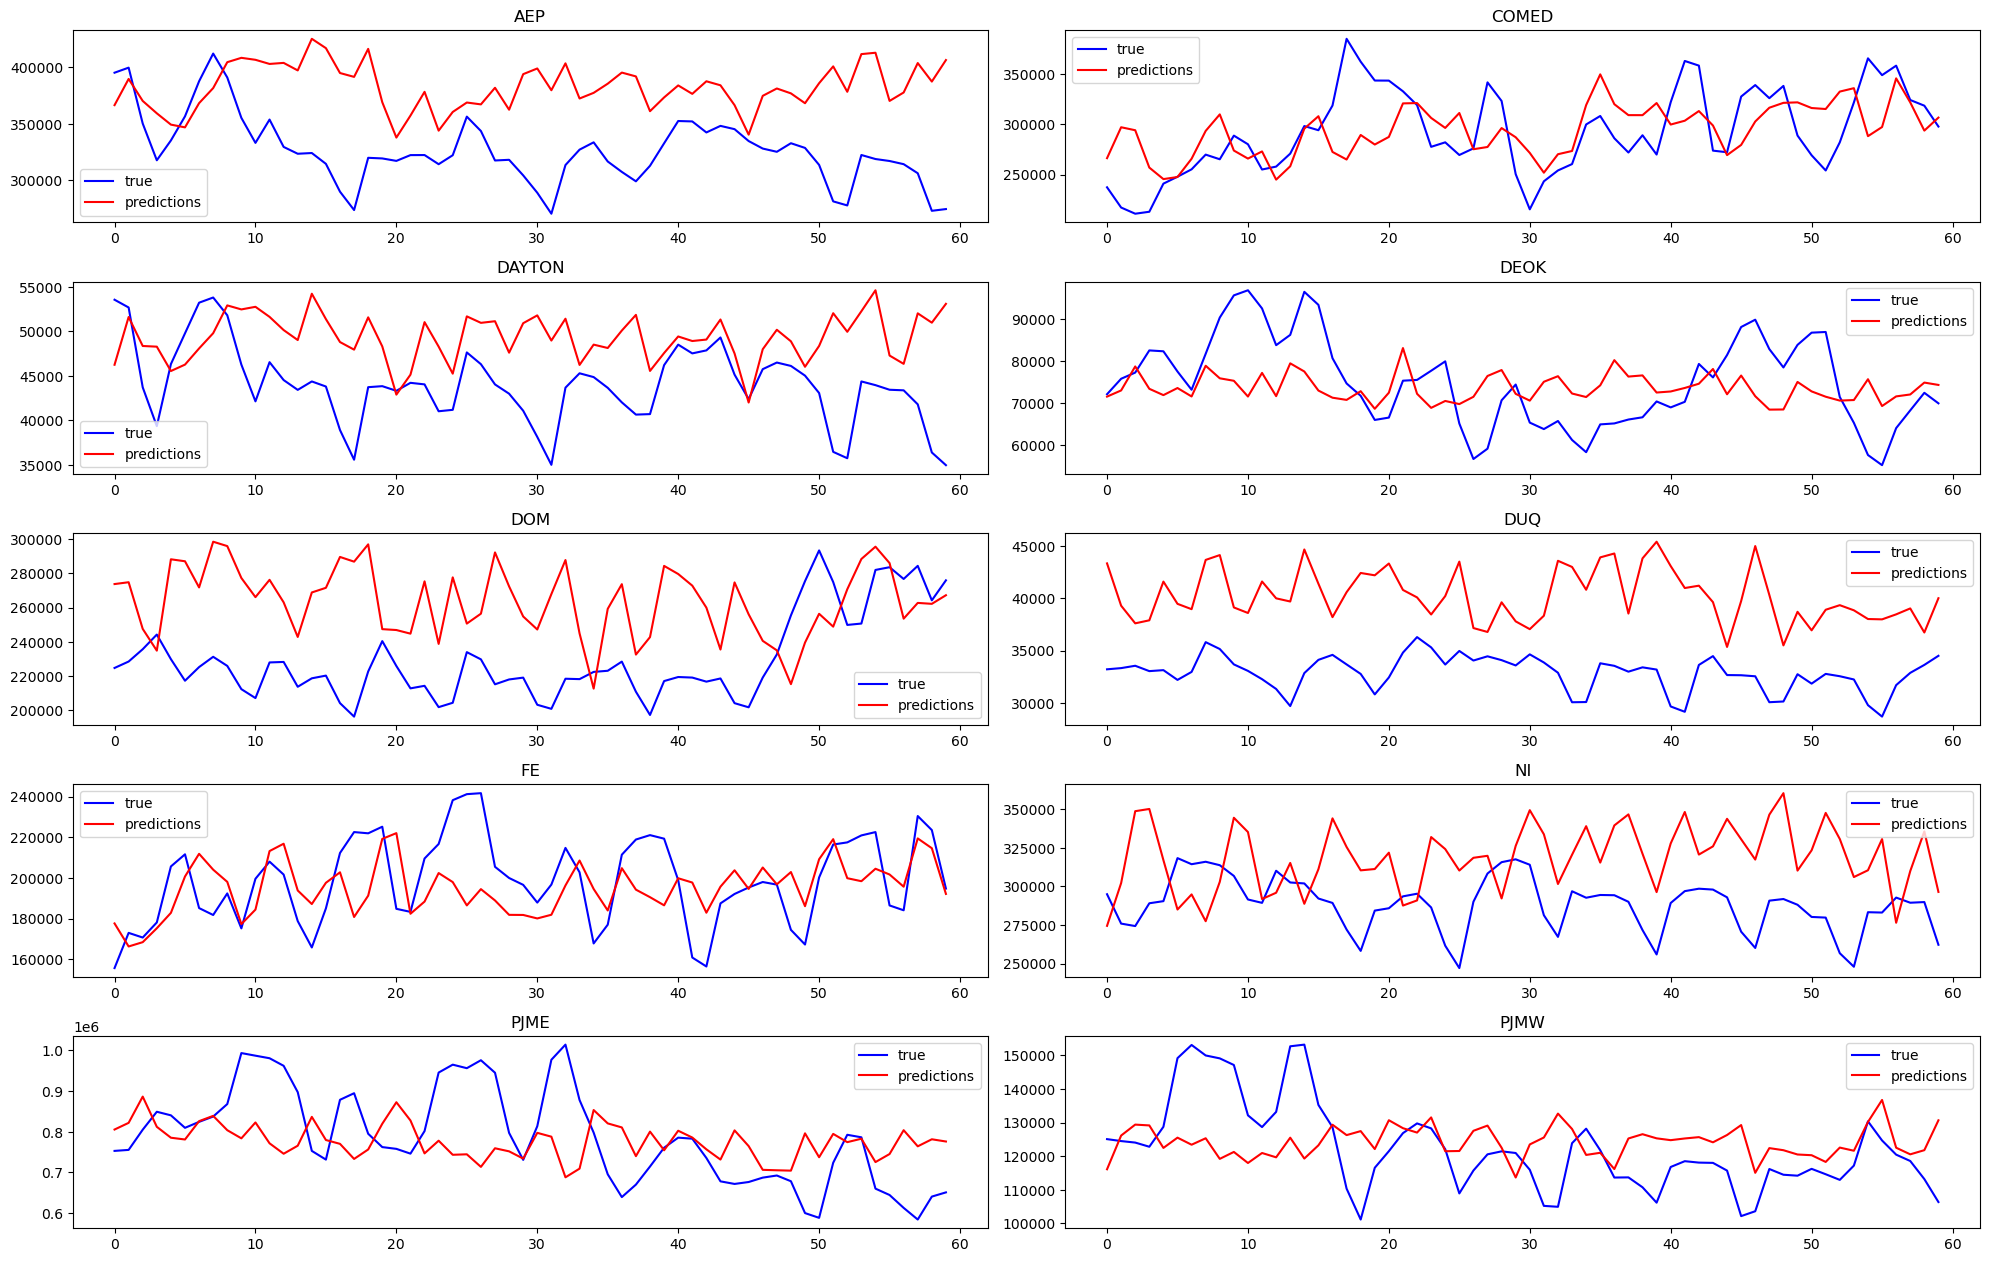

In [24]:
results = train(model, train_dl_list, optimizer, criterion, epochs)
true_val_list, predictions_list = predict_plot(model, val_ds_list)

In [25]:
SAVE_PATH = "lstm_results/models"
torch.save(model.state_dict(), SAVE_PATH + f"/{model_name}.pt")

RuntimeError: Parent directory lstm_results/models does not exist.